# Federated learning implementation on APTOS 2019 Blindness Detection Dataset.


In [ ]:
#pip install flwr[simulation]
#pip install flwr ray

Data Extraction

In [ ]:


# Create the kaggle.json file with your credentials
import json
import os

# Replace with your Kaggle username and API key
kaggle_credentials =xyz,
    "key": "xxyzzz"
}

# Path to save kaggle.json on Google Drive
kaggle_json_path = 'path'

# Save the credentials to the kaggle.json file
with open(kaggle_json_path, "w") as f:
    json.dump(kaggle_credentials, f)

# Set permissions for the kaggle.json file
os.makedirs("/root/.kaggle/", exist_ok=True)
!cp {kaggle_json_path} /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

# Verify that the kaggle.json file exists
!ls /root/.kaggle/

# Directory to save the dataset on Google Drive
dataset_path = '/content/drive/MyDrive/aptos2019-blindness-detection'

# Create the dataset directory if it doesn't exist
os.makedirs(dataset_path, exist_ok=True)

# Use Kaggle CLI to download the dataset directly to Google Drive
!kaggle competitions download -c aptos2019-blindness-detection -p {dataset_path}

# Unzip the dataset
!unzip {dataset_path}/aptos2019-blindness-detection.zip -d {dataset_path}


Resnet

Mobilenet_V2

In [ ]:
from collections import OrderedDict
from typing import List
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models
import pandas as pd
import os
import cv2
import flwr as fl
import ray
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}")
NUM_CLIENTS = 10
BATCH_SIZE = 32
NUM_CLASSES = 5  # Adjust this according to your dataset
BEST_MODEL_PATH = '/content/drive/MyDrive/aptos2019-blindness-detection/best_model.pth'

# Load data
def load_data():
    train = pd.read_csv('/content/drive/MyDrive/aptos2019-blindness-detection/train.csv')
    test = pd.read_csv('/content/drive/MyDrive/aptos2019-blindness-detection/test.csv')

    train_dir = '/content/drive/MyDrive/aptos2019-blindness-detection/train_images'
    test_dir = '/content/drive/MyDrive/aptos2019-blindness-detection/test_images'

    train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir, f'{x}.png'))
    test['file_path'] = test['id_code'].map(lambda x: os.path.join(test_dir, f'{x}.png'))

    train['diagnosis'] = train['diagnosis'].astype(int)

    return train, test

df_train, df_test = load_data()
print(df_train.shape, df_test.shape, '\n')
df_train.head(6)

# Custom Dataset class
class APTOSDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['file_path']
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.dataframe.iloc[idx]['diagnosis']
        if self.transform:
            image = self.transform(image)
        return image, label

# Data transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Create datasets and dataloaders
def create_dataloaders(df_train, df_test, num_clients):
    # Create a single Dataset object from df_train
    full_dataset = APTOSDataset(df_train, transform)

    # Calculate the partition size and handle any remainder
    dataset_size = len(full_dataset)
    partition_size = dataset_size // num_clients
    lengths = [partition_size] * num_clients
    remainder = dataset_size - sum(lengths)
    if remainder > 0:
        lengths[-1] += remainder

    # Split the dataset into `num_clients` partitions
    datasets = random_split(full_dataset, lengths, torch.Generator().manual_seed(42))

    # Create dataloaders for each client
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloader = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
        valloader = DataLoader(ds_val, batch_size=BATCH_SIZE)
        trainloaders.append(trainloader)
        valloaders.append(valloader)

    testloader = DataLoader(APTOSDataset(df_test, transform), batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader

trainloaders, valloaders, testloader = create_dataloaders(df_train, df_test, NUM_CLIENTS)

# Model definition using MobileNetV2
def create_mobilenetv2():
    model = models.mobilenet_v2(pretrained=True)
    model.classifier[1] = nn.Linear(model.last_channel, NUM_CLASSES)
    return model.to(DEVICE)

# Helper functions for model parameter extraction and loading
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

# Training and evaluation functions
def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss:.4f}, accuracy {epoch_acc:.4f}")

def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

# Flower client implementation
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader.dataset), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader.dataset), {"accuracy": float(accuracy)}

def client_fn(cid) -> FlowerClient:
    net = create_mobilenetv2()
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start Flower simulation
results = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=10),
    client_resources=client_resources,
)

# Extract the final parameters from the simulation results
final_parameters = results.parameters

# Evaluate the final model and save the best model
net = create_mobilenetv2()
set_parameters(net, final_parameters)
_, final_accuracy = test(net, testloader)
torch.save(net.state_dict(), BEST_MODEL_PATH)
print(f"Final Test Accuracy: {final_accuracy:.4f}")

# Plotting accuracy curve
accuracy_list = [client['accuracy'] for client in results.client_metrics]
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(accuracy_list) + 1), accuracy_list, marker='o')
plt.title('Test Accuracy per Round')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


Training on cpu using PyTorch 2.3.0+cu121 and Flower 1.9.0


INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout


(3662, 3) (1928, 2) 



/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-06-24 08:31:14,738	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'object_store_memory': 16339907788.0, 'memory': 32679815579.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=1849) 2024-06-24 08:31:16.808944: E external/

(ClientAppActor pid=1854) [Client 6] get_parameters


(ClientAppActor pid=1854) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(ClientAppActor pid=1854)   warnings.warn(
(ClientAppActor pid=1854) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
(ClientAppActor pid=1854)   warnings.warn(msg)
(ClientAppActor pid=1854) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1854) [Client 6] fit, config: {}


(ClientAppActor pid=1853) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(ClientAppActor pid=1853)   warnings.warn(
(ClientAppActor pid=1853) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
(ClientAppActor pid=1853)   warnings.warn(msg)
(ClientAppActor pid=1853) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1851) 

(ClientAppActor pid=1851) [Client 5] fit, config: {} [repeated 2x across cluster]


(ClientAppActor pid=1851) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1853) Epoch 1: train loss 0.0296, accuracy 0.6818
(ClientAppActor pid=1846) [Client 9] fit, config: {} [repeated 5x across cluster]


(ClientAppActor pid=1853) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 6x across cluster]
(ClientAppActor pid=1853)   warnings.warn( [repeated 6x across cluster]
(ClientAppActor pid=1853) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 6x across cluster]
(ClientAppActor pid=1853)   warnings.warn(msg) [repeated 6x across cluster]
(ClientAppActor pid=1846) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyCli

(ClientAppActor pid=1846) Epoch 1: train loss 0.0278, accuracy 0.6506
(ClientAppActor pid=1853) [Client 8] fit, config: {}
(ClientAppActor pid=1846) [Client 2] fit, config: {}


(ClientAppActor pid=1846) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(ClientAppActor pid=1846)   warnings.warn(
(ClientAppActor pid=1846) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
(ClientAppActor pid=1846)   warnings.warn(msg)
(ClientAppActor pid=1846) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluste

(ClientAppActor pid=1849) Epoch 1: train loss 0.0307, accuracy 0.6485
(ClientAppActor pid=1848) Epoch 1: train loss 0.0313, accuracy 0.6333 [repeated 3x across cluster]
(ClientAppActor pid=1851) Epoch 1: train loss 0.0290, accuracy 0.6697
(ClientAppActor pid=1852) Epoch 1: train loss 0.0346, accuracy 0.5758
(ClientAppActor pid=1853) Epoch 1: train loss 0.0314, accuracy 0.6848


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=1846) Epoch 1: train loss 0.0312, accuracy 0.6364


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=1846) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(ClientAppActor pid=1846)   warnings.warn(
(ClientAppActor pid=1846) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
(ClientAppActor pid=1846)   warnings.warn(msg)
(ClientAppActor pid=1846) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.t

(ClientAppActor pid=1853) [Client 5] evaluate, config: {}


(ClientAppActor pid=1853) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 8x across cluster]
(ClientAppActor pid=1853)   warnings.warn( [repeated 8x across cluster]
(ClientAppActor pid=1853) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 8x across cluster]
(ClientAppActor pid=1853)   warnings.warn(msg) [repeated 8x across cluster]
(ClientAppActor pid=1849) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyCli

(ClientAppActor pid=1853) [Client 6] evaluate, config: {} [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=1849) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 2x across cluster]
(ClientAppActor pid=1849)   warnings.warn( [repeated 2x across cluster]
(ClientAppActor pid=1849) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 2x across cluster]
(ClientAppActor pid=1849)   warnings.warn(msg) [repeated

(ClientAppActor pid=1854) [Client 6] fit, config: {}
(ClientAppActor pid=1849) [Client 1] evaluate, config: {}
(ClientAppActor pid=1854) Epoch 1: train loss 0.0329, accuracy 0.6424
(ClientAppActor pid=1848) [Client 9] fit, config: {} [repeated 7x across cluster]


(ClientAppActor pid=1854) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 8x across cluster]
(ClientAppActor pid=1854)   warnings.warn( [repeated 8x across cluster]
(ClientAppActor pid=1854) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 8x across cluster]
(ClientAppActor pid=1854)   warnings.warn(msg) [repeated 8x across cluster]
(ClientAppActor pid=1848) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyCli

(ClientAppActor pid=1851) Epoch 1: train loss 0.0284, accuracy 0.6970
(ClientAppActor pid=1854) [Client 7] fit, config: {}


(ClientAppActor pid=1851) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(ClientAppActor pid=1851)   warnings.warn(
(ClientAppActor pid=1851) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
(ClientAppActor pid=1851)   warnings.warn(msg)
(ClientAppActor pid=1854) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1851) 

(ClientAppActor pid=1851) [Client 0] fit, config: {}
(ClientAppActor pid=1849) Epoch 1: train loss 0.0218, accuracy 0.7606
(ClientAppActor pid=1853) Epoch 1: train loss 0.0288, accuracy 0.7121
(ClientAppActor pid=1848) Epoch 1: train loss 0.0255, accuracy 0.7169
(ClientAppActor pid=1854) Epoch 1: train loss 0.0282, accuracy 0.6545 [repeated 4x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=1850) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(ClientAppActor pid=1850)   warnings.warn(
(ClientAppActor pid=1850) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
(ClientAppActor pid=1850)   warnings.warn(msg)
(ClientAppActor pid=1850) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an ins

(ClientAppActor pid=1854) [Client 4] evaluate, config: {}


(ClientAppActor pid=1849) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 8x across cluster]
(ClientAppActor pid=1849)   warnings.warn( [repeated 8x across cluster]
(ClientAppActor pid=1849) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 8x across cluster]
(ClientAppActor pid=1849)   warnings.warn(msg) [repeated 8x across cluster]
(ClientAppActor pid=1848) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyCli

(ClientAppActor pid=1851) Epoch 1: train loss 0.0235, accuracy 0.7606
(ClientAppActor pid=1849) [Client 1] evaluate, config: {} [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=1849) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 2x across cluster]
(ClientAppActor pid=1849)   warnings.warn( [repeated 2x across cluster]
(ClientAppActor pid=1849) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 2x across cluster]
(ClientAppActor pid=1849)   warnings.warn(msg) [repeated

(ClientAppActor pid=1849) [Client 3] fit, config: {}
(ClientAppActor pid=1851) [Client 9] evaluate, config: {}
(ClientAppActor pid=1854) Epoch 1: train loss 0.0238, accuracy 0.7636
(ClientAppActor pid=1853) [Client 6] fit, config: {} [repeated 7x across cluster]


(ClientAppActor pid=1854) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 8x across cluster]
(ClientAppActor pid=1854)   warnings.warn( [repeated 8x across cluster]
(ClientAppActor pid=1854) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 8x across cluster]
(ClientAppActor pid=1854)   warnings.warn(msg) [repeated 8x across cluster]
(ClientAppActor pid=1854) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyCli

(ClientAppActor pid=1853) Epoch 1: train loss 0.0281, accuracy 0.7212 [repeated 2x across cluster]
(ClientAppActor pid=1851) [Client 2] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=1848) Epoch 1: train loss 0.0315, accuracy 0.7091 [repeated 3x across cluster]
(ClientAppActor pid=1854) Epoch 1: train loss 0.0248, accuracy 0.7636 [repeated 3x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=1851) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 2x across cluster]
(ClientAppActor pid=1851)   warnings.warn( [repeated 2x across cluster]
(ClientAppActor pid=1851) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 2x across cluster]
(ClientAppActor pid=1851)   warnings.warn(msg) [repeated 2x across cluster]
(ClientAppActor

(ClientAppActor pid=1854) [Client 6] evaluate, config: {}
(ClientAppActor pid=1851) Epoch 1: train loss 0.0231, accuracy 0.7485


(ClientAppActor pid=1849) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 8x across cluster]
(ClientAppActor pid=1849)   warnings.warn( [repeated 8x across cluster]
(ClientAppActor pid=1849) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 8x across cluster]
(ClientAppActor pid=1849)   warnings.warn(msg) [repeated 8x across cluster]
(ClientAppActor pid=1853) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyCli

(ClientAppActor pid=1849) [Client 3] evaluate, config: {} [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=1852) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 2x across cluster]
(ClientAppActor pid=1852)   warnings.warn( [repeated 2x across cluster]
(ClientAppActor pid=1852) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 2x across cluster]
(ClientAppActor pid=1852)   warnings.warn(msg) [repeated

(ClientAppActor pid=1852) [Client 6] fit, config: {}
(ClientAppActor pid=1852) [Client 8] evaluate, config: {}
(ClientAppActor pid=1851) Epoch 1: train loss 0.0215, accuracy 0.7667
(ClientAppActor pid=1848) [Client 5] fit, config: {} [repeated 7x across cluster]


(ClientAppActor pid=1851) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 8x across cluster]
(ClientAppActor pid=1851)   warnings.warn( [repeated 8x across cluster]
(ClientAppActor pid=1851) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 8x across cluster]
(ClientAppActor pid=1851)   warnings.warn(msg) [repeated 8x across cluster]
(ClientAppActor pid=1848) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyCli

(ClientAppActor pid=1854) Epoch 1: train loss 0.0240, accuracy 0.7303
(ClientAppActor pid=1854) [Client 9] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=1849) Epoch 1: train loss 0.0249, accuracy 0.7273
(ClientAppActor pid=1846) Epoch 1: train loss 0.0212, accuracy 0.7636 [repeated 4x across cluster]
(ClientAppActor pid=1854) Epoch 1: train loss 0.0233, accuracy 0.7229 [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=1851) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 2x across cluster]
(ClientAppActor pid=1851)   warnings.warn( [repeated 2x across cluster]
(ClientAppActor pid=1851) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 2x across cluster]
(ClientAppActor pid=1851)   warnings.warn(msg) [repeated 2x across cluster]
(ClientAppActor

(ClientAppActor pid=1854) [Client 1] evaluate, config: {}


(ClientAppActor pid=1851) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 8x across cluster]
(ClientAppActor pid=1851)   warnings.warn( [repeated 8x across cluster]
(ClientAppActor pid=1851) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 8x across cluster]
(ClientAppActor pid=1851)   warnings.warn(msg) [repeated 8x across cluster]
(ClientAppActor pid=1849) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyCli

(ClientAppActor pid=1851) Epoch 1: train loss 0.0290, accuracy 0.7000
(ClientAppActor pid=1851) [Client 3] evaluate, config: {} [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=1848) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 2x across cluster]
(ClientAppActor pid=1848)   warnings.warn( [repeated 2x across cluster]
(ClientAppActor pid=1848) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 2x across cluster]
(ClientAppActor pid=1848)   warnings.warn(msg) [repeated

(ClientAppActor pid=1848) [Client 2] fit, config: {}
(ClientAppActor pid=1848) [Client 5] evaluate, config: {}
(ClientAppActor pid=1854) Epoch 1: train loss 0.0227, accuracy 0.7199
(ClientAppActor pid=1846) [Client 5] fit, config: {} [repeated 7x across cluster]


(ClientAppActor pid=1854) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 8x across cluster]
(ClientAppActor pid=1854)   warnings.warn( [repeated 8x across cluster]
(ClientAppActor pid=1854) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 8x across cluster]
(ClientAppActor pid=1854)   warnings.warn(msg) [repeated 8x across cluster]
(ClientAppActor pid=1853) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyCli

(ClientAppActor pid=1849) Epoch 1: train loss 0.0238, accuracy 0.7303 [repeated 2x across cluster]
(ClientAppActor pid=1851) [Client 7] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=1848) Epoch 1: train loss 0.0185, accuracy 0.7909
(ClientAppActor pid=1852) Epoch 1: train loss 0.0178, accuracy 0.8061
(ClientAppActor pid=1854) Epoch 1: train loss 0.0185, accuracy 0.8212 [repeated 4x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1851) Epoch 1: train loss 0.0219, accuracy 0.7515


(ClientAppActor pid=1851) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 2x across cluster]
(ClientAppActor pid=1851)   warnings.warn( [repeated 2x across cluster]
(ClientAppActor pid=1851) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 2x across cluster]
(ClientAppActor pid=1851)   warnings.warn(msg) [repeated 2x across cluster]
(ClientAppActor pid=1851) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyCli

(ClientAppActor pid=1851) [Client 5] evaluate, config: {}


(ClientAppActor pid=1853) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 8x across cluster]
(ClientAppActor pid=1853)   warnings.warn( [repeated 8x across cluster]
(ClientAppActor pid=1853) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 8x across cluster]
(ClientAppActor pid=1853)   warnings.warn(msg) [repeated 8x across cluster]
(ClientAppActor pid=1849) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyCli

(ClientAppActor pid=1853) [Client 3] evaluate, config: {} [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=1849) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 2x across cluster]
(ClientAppActor pid=1849)   warnings.warn( [repeated 2x across cluster]
(ClientAppActor pid=1849) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 2x across cluster]
(ClientAppActor pid=1849)   warnings.warn(msg) [repeated

(ClientAppActor pid=1853) [Client 6] fit, config: {}
(ClientAppActor pid=1851) [Client 1] evaluate, config: {}
(ClientAppActor pid=1854) Epoch 1: train loss 0.0179, accuracy 0.7879
(ClientAppActor pid=1848) [Client 9] fit, config: {} [repeated 7x across cluster]


(ClientAppActor pid=1854) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 8x across cluster]
(ClientAppActor pid=1854)   warnings.warn( [repeated 8x across cluster]
(ClientAppActor pid=1854) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 8x across cluster]
(ClientAppActor pid=1854)   warnings.warn(msg) [repeated 8x across cluster]
(ClientAppActor pid=1848) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyCli

(ClientAppActor pid=1849) Epoch 1: train loss 0.0204, accuracy 0.8333 [repeated 2x across cluster]
(ClientAppActor pid=1851) [Client 3] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=1852) Epoch 1: train loss 0.0285, accuracy 0.7242 [repeated 2x across cluster]
(ClientAppActor pid=1854) Epoch 1: train loss 0.0181, accuracy 0.7909 [repeated 4x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=1851) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 2x across cluster]
(ClientAppActor pid=1851)   warnings.warn( [repeated 2x across cluster]
(ClientAppActor pid=1851) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 2x across cluster]
(ClientAppActor pid=1851)   warnings.warn(msg) [repeated 2x across cluster]
(ClientAppActor

(ClientAppActor pid=1851) [Client 1] evaluate, config: {}


(ClientAppActor pid=1854) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 8x across cluster]
(ClientAppActor pid=1854)   warnings.warn( [repeated 8x across cluster]
(ClientAppActor pid=1854) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 8x across cluster]
(ClientAppActor pid=1854)   warnings.warn(msg) [repeated 8x across cluster]
(ClientAppActor pid=1849) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyCli

(ClientAppActor pid=1851) Epoch 1: train loss 0.0186, accuracy 0.7818
(ClientAppActor pid=1854) [Client 5] evaluate, config: {} [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=1853) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 2x across cluster]
(ClientAppActor pid=1853)   warnings.warn( [repeated 2x across cluster]
(ClientAppActor pid=1853) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 2x across cluster]
(ClientAppActor pid=1853)   warnings.warn(msg) [repeated

(ClientAppActor pid=1853) [Client 6] fit, config: {}
(ClientAppActor pid=1853) [Client 7] evaluate, config: {}
(ClientAppActor pid=1854) Epoch 1: train loss 0.0156, accuracy 0.8091
(ClientAppActor pid=1848) [Client 4] fit, config: {} [repeated 7x across cluster]


(ClientAppActor pid=1854) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 8x across cluster]
(ClientAppActor pid=1854)   warnings.warn( [repeated 8x across cluster]
(ClientAppActor pid=1854) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 8x across cluster]
(ClientAppActor pid=1854)   warnings.warn(msg) [repeated 8x across cluster]
(ClientAppActor pid=1850) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyCli

(ClientAppActor pid=1850) Epoch 1: train loss 0.0167, accuracy 0.8121 [repeated 2x across cluster]
(ClientAppActor pid=1851) [Client 7] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=1846) Epoch 1: train loss 0.0209, accuracy 0.7818 [repeated 5x across cluster]
(ClientAppActor pid=1854) Epoch 1: train loss 0.0162, accuracy 0.7970


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=1851) Epoch 1: train loss 0.0191, accuracy 0.7758


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=1851) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 2x across cluster]
(ClientAppActor pid=1851)   warnings.warn( [repeated 2x across cluster]
(ClientAppActor pid=1851) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 2x across cluster]
(ClientAppActor pid=1851)   warnings.warn(msg) [repeated 2x across cluster]
(ClientAppActor pid=1851) WARNING :   Deprecation Warning: The `client_fn` fu

(ClientAppActor pid=1854) [Client 1] evaluate, config: {}


(ClientAppActor pid=1852) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 8x across cluster]
(ClientAppActor pid=1852)   warnings.warn( [repeated 8x across cluster]
(ClientAppActor pid=1852) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 8x across cluster]
(ClientAppActor pid=1852)   warnings.warn(msg) [repeated 8x across cluster]
(ClientAppActor pid=1850) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyCli

(ClientAppActor pid=1852) [Client 4] evaluate, config: {} [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=1852) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 2x across cluster]
(ClientAppActor pid=1852)   warnings.warn( [repeated 2x across cluster]
(ClientAppActor pid=1852) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 2x across cluster]
(ClientAppActor pid=1852)   warnings.warn(msg) [repeated

(ClientAppActor pid=1852) [Client 3] fit, config: {}
(ClientAppActor pid=1850) [Client 3] evaluate, config: {}
(ClientAppActor pid=1854) Epoch 1: train loss 0.0212, accuracy 0.7758
(ClientAppActor pid=1849) [Client 2] fit, config: {} [repeated 7x across cluster]


(ClientAppActor pid=1854) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 8x across cluster]
(ClientAppActor pid=1854)   warnings.warn( [repeated 8x across cluster]
(ClientAppActor pid=1854) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 8x across cluster]
(ClientAppActor pid=1854)   warnings.warn(msg) [repeated 8x across cluster]
(ClientAppActor pid=1853) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyCli

(ClientAppActor pid=1851) Epoch 1: train loss 0.0191, accuracy 0.7741
(ClientAppActor pid=1854) [Client 1] fit, config: {}
(ClientAppActor pid=1851) [Client 7] fit, config: {}


(ClientAppActor pid=1851) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(ClientAppActor pid=1851)   warnings.warn(
(ClientAppActor pid=1851) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
(ClientAppActor pid=1851)   warnings.warn(msg)
(ClientAppActor pid=1854) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1851) 

(ClientAppActor pid=1853) Epoch 1: train loss 0.0215, accuracy 0.7788
(ClientAppActor pid=1850) Epoch 1: train loss 0.0176, accuracy 0.8242 [repeated 4x across cluster]
(ClientAppActor pid=1854) Epoch 1: train loss 0.0209, accuracy 0.7848 [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=1851) Epoch 1: train loss 0.0159, accuracy 0.8394


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=1846) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(ClientAppActor pid=1846)   warnings.warn(
(ClientAppActor pid=1846) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
(ClientAppActor pid=1846)   warnings.warn(msg)
(ClientAppActor pid=1851) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.t

(ClientAppActor pid=1854) [Client 8] evaluate, config: {}


(ClientAppActor pid=1852) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 8x across cluster]
(ClientAppActor pid=1852)   warnings.warn( [repeated 8x across cluster]
(ClientAppActor pid=1852) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 8x across cluster]
(ClientAppActor pid=1852)   warnings.warn(msg) [repeated 8x across cluster]
(ClientAppActor pid=1846) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyCli

(ClientAppActor pid=1852) [Client 9] evaluate, config: {} [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=1852) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 2x across cluster]
(ClientAppActor pid=1852)   warnings.warn( [repeated 2x across cluster]
(ClientAppActor pid=1852) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 2x across cluster]
(ClientAppActor pid=1852)   warnings.warn(msg) [repeated

(ClientAppActor pid=1852) [Client 3] fit, config: {}
(ClientAppActor pid=1853) [Client 3] evaluate, config: {}
(ClientAppActor pid=1851) Epoch 1: train loss 0.0202, accuracy 0.8030
(ClientAppActor pid=1846) [Client 4] fit, config: {} [repeated 7x across cluster]


(ClientAppActor pid=1851) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 8x across cluster]
(ClientAppActor pid=1851)   warnings.warn( [repeated 8x across cluster]
(ClientAppActor pid=1851) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 8x across cluster]
(ClientAppActor pid=1851)   warnings.warn(msg) [repeated 8x across cluster]
(ClientAppActor pid=1849) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyCli

(ClientAppActor pid=1848) Epoch 1: train loss 0.0161, accuracy 0.8333 [repeated 3x across cluster]
(ClientAppActor pid=1854) [Client 9] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=1852) Epoch 1: train loss 0.0179, accuracy 0.8121
(ClientAppActor pid=1853) Epoch 1: train loss 0.0208, accuracy 0.8000
(ClientAppActor pid=1854) Epoch 1: train loss 0.0141, accuracy 0.8163 [repeated 3x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=1850) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 2x across cluster]
(ClientAppActor pid=1850)   warnings.warn( [repeated 2x across cluster]
(ClientAppActor pid=1850) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 2x across cluster]
(ClientAppActor pid=1850)   warnings.warn(msg) [repeated 2x across cluster]
(ClientAppActor

(ClientAppActor pid=1854) [Client 7] evaluate, config: {}


(ClientAppActor pid=1849) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 8x across cluster]
(ClientAppActor pid=1849)   warnings.warn( [repeated 8x across cluster]
(ClientAppActor pid=1849) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 8x across cluster]
(ClientAppActor pid=1849)   warnings.warn(msg) [repeated 8x across cluster]
(ClientAppActor pid=1848) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyCli

(ClientAppActor pid=1851) Epoch 1: train loss 0.0197, accuracy 0.8152
(ClientAppActor pid=1853) [Client 1] evaluate, config: {} [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=1852) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 2x across cluster]
(ClientAppActor pid=1852)   warnings.warn( [repeated 2x across cluster]
(ClientAppActor pid=1852) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 2x across cluster]
(ClientAppActor pid=1852)   warnings.warn(msg) [repeate

(ClientAppActor pid=1852) [Client 5] fit, config: {}
(ClientAppActor pid=1849) [Client 8] evaluate, config: {}
(ClientAppActor pid=1854) Epoch 1: train loss 0.0187, accuracy 0.8091
(ClientAppActor pid=1850) [Client 4] fit, config: {} [repeated 7x across cluster]


(ClientAppActor pid=1854) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 8x across cluster]
(ClientAppActor pid=1854)   warnings.warn( [repeated 8x across cluster]
(ClientAppActor pid=1854) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 8x across cluster]
(ClientAppActor pid=1854)   warnings.warn(msg) [repeated 8x across cluster]
(ClientAppActor pid=1854) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyCli

(ClientAppActor pid=1849) Epoch 1: train loss 0.0183, accuracy 0.8273
(ClientAppActor pid=1854) [Client 7] fit, config: {}
(ClientAppActor pid=1851) Epoch 1: train loss 0.0165, accuracy 0.8121


(ClientAppActor pid=1849) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(ClientAppActor pid=1849)   warnings.warn(
(ClientAppActor pid=1849) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
(ClientAppActor pid=1849)   warnings.warn(msg)
(ClientAppActor pid=1854) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1849) 

(ClientAppActor pid=1849) [Client 9] fit, config: {}
(ClientAppActor pid=1850) Epoch 1: train loss 0.0189, accuracy 0.8030 [repeated 3x across cluster]
(ClientAppActor pid=1854) Epoch 1: train loss 0.0202, accuracy 0.7848 [repeated 3x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=1849) Epoch 1: train loss 0.0186, accuracy 0.8072


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=1846) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(ClientAppActor pid=1846)   warnings.warn(
(ClientAppActor pid=1846) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
(ClientAppActor pid=1846)   warnings.warn(msg)
(ClientAppActor pid=1846) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.t

(ClientAppActor pid=1854) [Client 2] evaluate, config: {}


(ClientAppActor pid=1849) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 8x across cluster]
(ClientAppActor pid=1849)   warnings.warn( [repeated 8x across cluster]
(ClientAppActor pid=1849) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 8x across cluster]
(ClientAppActor pid=1849)   warnings.warn(msg) [repeated 8x across cluster]
(ClientAppActor pid=1848) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyCli

(ClientAppActor pid=1854) [Client 9] evaluate, config: {} [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 2869.93s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.06615336934725444
INFO :      		round 2: 0.036889012613230285
INFO :      		round 3: 0.039395290695958665
INFO :      		round 4: 0.04096006786243783
INFO :      		round 5: 0.03933790961487426
INFO :      		round 6: 0.040691786507765455
INFO :      		round 7: 0.0383206677933534
INFO :      		round 8: 0.03930400235371457
INFO :      		round 9: 0.04224831648170948
INFO :      		round 10: 0.04028877524865998
INFO :      


AttributeError: 'History' object has no attribute 'parameters'

In [ ]:
from collections import OrderedDict
from typing import List
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models
import pandas as pd
import os
import cv2
import flwr as fl
import ray
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}")
NUM_CLIENTS = 4
BATCH_SIZE = 64
NUM_CLASSES = 5  # Adjust this according to your dataset
BEST_MODEL_PATH = '/content/drive/MyDrive/aptos2019-blindness-detection/best_model.pth'

# Load data
def load_data():
    train = pd.read_csv('/content/drive/MyDrive/aptos2019-blindness-detection/train.csv')
    test = pd.read_csv('/content/drive/MyDrive/aptos2019-blindness-detection/test.csv')

    train_dir = '/content/drive/MyDrive/aptos2019-blindness-detection/train_images'
    test_dir = '/content/drive/MyDrive/aptos2019-blindness-detection/test_images'

    train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir, f'{x}.png'))
    test['file_path'] = test['id_code'].map(lambda x: os.path.join(test_dir, f'{x}.png'))

    train['diagnosis'] = train['diagnosis'].astype(int)

    return train, test

df_train, df_test = load_data()
print(df_train.shape, df_test.shape, '\n')
df_train.head(6)

# Custom Dataset class
class APTOSDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['file_path']
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.dataframe.iloc[idx]['diagnosis']
        if self.transform:
            image = self.transform(image)
        return image, label

# Data transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Create datasets and dataloaders
def create_dataloaders(df_train, df_test, num_clients):
    # Create a single Dataset object from df_train
    full_dataset = APTOSDataset(df_train, transform)

    # Calculate the partition size and handle any remainder
    dataset_size = len(full_dataset)
    partition_size = dataset_size // num_clients
    lengths = [partition_size] * num_clients
    remainder = dataset_size - sum(lengths)
    if remainder > 0:
        lengths[-1] += remainder

    # Split the dataset into `num_clients` partitions
    datasets = random_split(full_dataset, lengths, torch.Generator().manual_seed(42))

    # Create dataloaders for each client
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloader = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
        valloader = DataLoader(ds_val, batch_size=BATCH_SIZE)
        trainloaders.append(trainloader)
        valloaders.append(valloader)

    testloader = DataLoader(APTOSDataset(df_test, transform), batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader

trainloaders, valloaders, testloader = create_dataloaders(df_train, df_test, NUM_CLIENTS)

# Model definition using MobileNetV2
def create_mobilenetv2():
    model = models.mobilenet_v2(pretrained=True)
    model.classifier[1] = nn.Linear(model.last_channel, NUM_CLASSES)
    return model.to(DEVICE)

# Helper functions for model parameter extraction and loading
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

# Training and evaluation functions
def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss:.4f}, accuracy {epoch_acc:.4f}")

def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

# Flower client implementation
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader.dataset), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader.dataset), {"accuracy": float(accuracy)}

def client_fn(cid) -> fl.client.Client:
    net = create_mobilenetv2()
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    numpy_client = FlowerClient(cid, net, trainloader, valloader)
    return fl.client.NumPyClient.to_client(numpy_client)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start Flower simulation
results = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=10),
    client_resources=client_resources,
)

# Extract the final parameters from the simulation results
final_parameters = results.metrics_centralized["parameters"][-1] if "parameters" in results.metrics_centralized else None

if final_parameters is not None:
    # Evaluate the final model and save the best model
    net = create_mobilenetv2()
    set_parameters(net, final_parameters)
    _, final_accuracy = test(net, testloader)
    torch.save(net.state_dict(), BEST_MODEL_PATH)
    print(f"Final Test Accuracy: {final_accuracy:.4f}")

    # Plotting accuracy curve
    accuracy_list = [metric["accuracy"] for metric in results.metrics_centralized["accuracy"]]
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(accuracy_list) + 1), accuracy_list, marker='o')
    plt.title('Test Accuracy per Round')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')



INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout


Training on cpu using PyTorch 2.3.0+cu121 and Flower 1.9.0
(3662, 3) (1928, 2) 



/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-06-24 11:08:24,539	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'object_store_memory': 16340285030.0, 'memory': 32680570062.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'CPU': 8.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=44656) 2024-06-24 11:08:26.542360: E external

(ClientAppActor pid=44660) [Client 0] get_parameters
(ClientAppActor pid=44660) [Client 2] fit, config: {}
(ClientAppActor pid=44660) Epoch 1: train loss 0.0135, accuracy 0.6650
(ClientAppActor pid=44657) [Client 0] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=44658) Epoch 1: train loss 0.0139, accuracy 0.6505
(ClientAppActor pid=44657) Epoch 1: train loss 0.0124, accuracy 0.7027


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)
(ClientAppActor pid=44659) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 4x across cluster]
(ClientAppActor pid=44659)   warnings.warn( [repeated 4x across cluster]
(ClientAppActor pid=44659) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 4x across cluster]
(ClientAppActor pid=44659)   warnings.warn(msg) [repeated 4x across cluster]


(ClientAppActor pid=44658) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)
(ClientAppActor pid=44658) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 4x across cluster]
(ClientAppActor pid=44658)   warnings.warn( [repeated 4x across cluster]
(ClientAppActor pid=44658) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 4x across cluster]
(ClientAppActor pid=44658)   warnings.warn(msg) [repeate

(ClientAppActor pid=44658) [Client 0] fit, config: {}
(ClientAppActor pid=44659) Epoch 1: train loss 0.0141, accuracy 0.6550
(ClientAppActor pid=44660) [Client 3] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=44658) Epoch 1: train loss 0.0111, accuracy 0.7354
(ClientAppActor pid=44657) [Client 2] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=44657) Epoch 1: train loss 0.0114, accuracy 0.7391
(ClientAppActor pid=44659) Epoch 1: train loss 0.0111, accuracy 0.7330


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=44660) Epoch 1: train loss 0.0118, accuracy 0.7252


(ClientAppActor pid=44660) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 4x across cluster]
(ClientAppActor pid=44660)   warnings.warn( [repeated 4x across cluster]
(ClientAppActor pid=44660) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 4x across cluster]
(ClientAppActor pid=44660)   warnings.warn(msg) [repeated 4x across cluster]


(ClientAppActor pid=44660) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)
(ClientAppActor pid=44660) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 4x across cluster]
(ClientAppActor pid=44660)   warnings.warn( [repeated 4x across cluster]
(ClientAppActor pid=44660) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 4x across cluster]
(ClientAppActor pid=44660)   warnings.warn(msg) [repeate

(ClientAppActor pid=44660) [Client 0] fit, config: {}
(ClientAppActor pid=44658) [Client 2] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=44658) Epoch 1: train loss 0.0100, accuracy 0.7682
(ClientAppActor pid=44659) [Client 3] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=44657) Epoch 1: train loss 0.0097, accuracy 0.7658
(ClientAppActor pid=44660) Epoch 1: train loss 0.0091, accuracy 0.8010


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=44659) Epoch 1: train loss 0.0109, accuracy 0.7542


(ClientAppActor pid=44660) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 4x across cluster]
(ClientAppActor pid=44660)   warnings.warn( [repeated 4x across cluster]
(ClientAppActor pid=44660) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 4x across cluster]
(ClientAppActor pid=44660)   warnings.warn(msg) [repeated 4x across cluster]


(ClientAppActor pid=44660) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)
(ClientAppActor pid=44657) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 4x across cluster]
(ClientAppActor pid=44657)   warnings.warn( [repeated 4x across cluster]
(ClientAppActor pid=44657) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 4x across cluster]
(ClientAppActor pid=44657)   warnings.warn(msg) [repeate

(ClientAppActor pid=44658) [Client 0] fit, config: {}
(ClientAppActor pid=44658) [Client 2] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=44658) Epoch 1: train loss 0.0084, accuracy 0.8083
(ClientAppActor pid=44659) [Client 3] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=44657) Epoch 1: train loss 0.0094, accuracy 0.7633
(ClientAppActor pid=44660) Epoch 1: train loss 0.0097, accuracy 0.7803


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)
(ClientAppActor pid=44659) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 4x across cluster]
(ClientAppActor pid=44659)   warnings.warn( [repeated 4x across cluster]
(ClientAppActor pid=44659) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 4x across cluster]
(ClientAppActor pid=44659)   warnings.warn(msg) [repeated 4x across cluster]


(ClientAppActor pid=44659) Epoch 1: train loss 0.0101, accuracy 0.7506
(ClientAppActor pid=44660) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)
(ClientAppActor pid=44658) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 4x across cluster]
(ClientAppActor pid=44658)   warnings.warn( [repeated 4x across cluster]
(ClientAppActor pid=44658) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 4x across cluster]
(ClientAppActor pid=44658)   warnings.warn(msg) [repeate

(ClientAppActor pid=44660) [Client 2] fit, config: {}
(ClientAppActor pid=44657) [Client 3] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=44658) Epoch 1: train loss 0.0077, accuracy 0.8192
(ClientAppActor pid=44657) [Client 3] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=44657) Epoch 1: train loss 0.0080, accuracy 0.8051
(ClientAppActor pid=44660) Epoch 1: train loss 0.0082, accuracy 0.8058


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)
(ClientAppActor pid=44660) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 4x across cluster]
(ClientAppActor pid=44660)   warnings.warn( [repeated 4x across cluster]
(ClientAppActor pid=44660) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 4x across cluster]
(ClientAppActor pid=44660)   warnings.warn(msg) [repeated 4x across cluster]


(ClientAppActor pid=44659) [Client 3] evaluate, config: {}


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)
(ClientAppActor pid=44657) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 4x across cluster]
(ClientAppActor pid=44657)   warnings.warn( [repeated 4x across cluster]
(ClientAppActor pid=44657) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 4x across cluster]
(ClientAppActor pid=44657)   warnings.warn(msg) [repeate

(ClientAppActor pid=44660) [Client 3] fit, config: {}
(ClientAppActor pid=44659) Epoch 1: train loss 0.0075, accuracy 0.8289
(ClientAppActor pid=44657) [Client 1] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=44658) Epoch 1: train loss 0.0082, accuracy 0.8022
(ClientAppActor pid=44659) [Client 0] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=44657) Epoch 1: train loss 0.0080, accuracy 0.8010
(ClientAppActor pid=44659) Epoch 1: train loss 0.0067, accuracy 0.8483


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)
(ClientAppActor pid=44657) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 4x across cluster]
(ClientAppActor pid=44657)   warnings.warn( [repeated 4x across cluster]
(ClientAppActor pid=44657) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 4x across cluster]
(ClientAppActor pid=44657)   warnings.warn(msg) [repeated 4x across cluster]


(ClientAppActor pid=44660) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)
(ClientAppActor pid=44657) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 4x across cluster]
(ClientAppActor pid=44657)   warnings.warn( [repeated 4x across cluster]
(ClientAppActor pid=44657) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 4x across cluster]
(ClientAppActor pid=44657)   warnings.warn(msg) [repeate

(ClientAppActor pid=44660) [Client 0] fit, config: {}
(ClientAppActor pid=44660) Epoch 1: train loss 0.0089, accuracy 0.7918
(ClientAppActor pid=44658) [Client 1] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=44658) Epoch 1: train loss 0.0074, accuracy 0.8252
(ClientAppActor pid=44659) [Client 3] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=44657) Epoch 1: train loss 0.0076, accuracy 0.8228
(ClientAppActor pid=44660) Epoch 1: train loss 0.0071, accuracy 0.8277


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)
(ClientAppActor pid=44660) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 4x across cluster]
(ClientAppActor pid=44660)   warnings.warn( [repeated 4x across cluster]
(ClientAppActor pid=44660) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 4x across cluster]
(ClientAppActor pid=44660)   warnings.warn(msg) [repeated 4x across cluster]


(ClientAppActor pid=44659) Epoch 1: train loss 0.0081, accuracy 0.8075
(ClientAppActor pid=44659) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)
(ClientAppActor pid=44659) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 4x across cluster]
(ClientAppActor pid=44659)   warnings.warn( [repeated 4x across cluster]
(ClientAppActor pid=44659) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 4x across cluster]
(ClientAppActor pid=44659)   warnings.warn(msg) [repeate

(ClientAppActor pid=44657) [Client 2] fit, config: {}
(ClientAppActor pid=44657) [Client 2] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=44658) Epoch 1: train loss 0.0062, accuracy 0.8483
(ClientAppActor pid=44658) [Client 1] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=44657) Epoch 1: train loss 0.0067, accuracy 0.8374
(ClientAppActor pid=44659) Epoch 1: train loss 0.0070, accuracy 0.8277


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)
(ClientAppActor pid=44660) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 4x across cluster]
(ClientAppActor pid=44660)   warnings.warn( [repeated 4x across cluster]
(ClientAppActor pid=44660) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 4x across cluster]
(ClientAppActor pid=44660)   warnings.warn(msg) [repeated 4x across cluster]


(ClientAppActor pid=44659) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)
(ClientAppActor pid=44659) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 4x across cluster]
(ClientAppActor pid=44659)   warnings.warn( [repeated 4x across cluster]
(ClientAppActor pid=44659) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 4x across cluster]
(ClientAppActor pid=44659)   warnings.warn(msg) [repeate

(ClientAppActor pid=44660) [Client 2] fit, config: {}
(ClientAppActor pid=44660) Epoch 1: train loss 0.0068, accuracy 0.8269
(ClientAppActor pid=44660) [Client 3] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=44658) Epoch 1: train loss 0.0067, accuracy 0.8426
(ClientAppActor pid=44658) [Client 3] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=44660) Epoch 1: train loss 0.0062, accuracy 0.8544
(ClientAppActor pid=44657) Epoch 1: train loss 0.0057, accuracy 0.8532


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)
(ClientAppActor pid=44659) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 4x across cluster]
(ClientAppActor pid=44659)   warnings.warn( [repeated 4x across cluster]
(ClientAppActor pid=44659) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 4x across cluster]
(ClientAppActor pid=44659)   warnings.warn(msg) [repeated 4x across cluster]


(ClientAppActor pid=44660) [Client 3] evaluate, config: {}


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)
(ClientAppActor pid=44657) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 4x across cluster]
(ClientAppActor pid=44657)   warnings.warn( [repeated 4x across cluster]
(ClientAppActor pid=44657) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 4x across cluster]
(ClientAppActor pid=44657)   warnings.warn(msg) [repeat

(ClientAppActor pid=44658) [Client 1] fit, config: {}
(ClientAppActor pid=44659) Epoch 1: train loss 0.0065, accuracy 0.8519
(ClientAppActor pid=44659) [Client 1] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=44658) Epoch 1: train loss 0.0052, accuracy 0.8786
(ClientAppActor pid=44660) [Client 3] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=44659) Epoch 1: train loss 0.0054, accuracy 0.8726
(ClientAppActor pid=44657) Epoch 1: train loss 0.0054, accuracy 0.8799


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)
(ClientAppActor pid=44657) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 4x across cluster]
(ClientAppActor pid=44657)   warnings.warn( [repeated 4x across cluster]
(ClientAppActor pid=44657) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights. [repeated 4x across cluster]
(ClientAppActor pid=44657)   warnings.warn(msg) [repeated 4x across cluster]


(ClientAppActor pid=44660) [Client 3] evaluate, config: {}


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 2290.56s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.024228526258861627
INFO :      		round 2: 0.017529774825651566
INFO :      		round 3: 0.014032434139932905
INFO :      		round 4: 0.011900801006909255
INFO :      		round 5: 0.011185917102701061
INFO :      		round 6: 0.013216613126652581
INFO :      		round 7: 0.010013944172597194
INFO :      		round 8: 0.012239336558095702
INFO :      		round 9: 0.015126594639086461
INFO :      		round 10: 0.009813950693869328
INFO :      


SqueezNet

1.1

In [ ]:
from collections import OrderedDict
from typing import List
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models
import pandas as pd
import os
import cv2
import flwr as fl
import ray
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}")
NUM_CLIENTS = 4
BATCH_SIZE = 64
NUM_CLASSES = 5  # Adjust this according to your dataset
BEST_MODEL_PATH = '/content/drive/MyDrive/aptos2019-blindness-detection/best_model.pth'

# Load data
def load_data():
    train = pd.read_csv('/content/drive/MyDrive/aptos2019-blindness-detection/train.csv')
    test = pd.read_csv('/content/drive/MyDrive/aptos2019-blindness-detection/test.csv')

    train_dir = '/content/drive/MyDrive/aptos2019-blindness-detection/train_images'
    test_dir = '/content/drive/MyDrive/aptos2019-blindness-detection/test_images'

    train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir, f'{x}.png'))
    test['file_path'] = test['id_code'].map(lambda x: os.path.join(test_dir, f'{x}.png'))

    train['diagnosis'] = train['diagnosis'].astype(int)

    return train, test

df_train, df_test = load_data()
print(df_train.shape, df_test.shape, '\n')
df_train.head(6)

# Custom Dataset class
class APTOSDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['file_path']
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.dataframe.iloc[idx]['diagnosis']
        if self.transform:
            image = self.transform(image)
        return image, label

# Data transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Create datasets and dataloaders
def create_dataloaders(df_train, df_test, num_clients):
    # Create a single Dataset object from df_train
    full_dataset = APTOSDataset(df_train, transform)

    # Calculate the partition size and handle any remainder
    dataset_size = len(full_dataset)
    partition_size = dataset_size // num_clients
    lengths = [partition_size] * num_clients
    remainder = dataset_size - sum(lengths)
    if remainder > 0:
        lengths[-1] += remainder

    # Split the dataset into `num_clients` partitions
    datasets = random_split(full_dataset, lengths, torch.Generator().manual_seed(42))

    # Create dataloaders for each client
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloader = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
        valloader = DataLoader(ds_val, batch_size=BATCH_SIZE)
        trainloaders.append(trainloader)
        valloaders.append(valloader)

    testloader = DataLoader(APTOSDataset(df_test, transform), batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader

trainloaders, valloaders, testloader = create_dataloaders(df_train, df_test, NUM_CLIENTS)

# Model definition using SqueezeNet
def create_squeezenet():
    model = models.squeezenet1_1(pretrained=True)
    model.classifier[1] = nn.Conv2d(512, NUM_CLASSES, kernel_size=(1,1), stride=(1,1))
    model.num_classes = NUM_CLASSES
    return model.to(DEVICE)

# Helper functions for model parameter extraction and loading
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

# Training and evaluation functions
def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss:.4f}, accuracy {epoch_acc:.4f}")

def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

# Flower client implementation
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader.dataset), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader.dataset), {"accuracy": float(accuracy)}

def client_fn(cid) -> fl.client.Client:
    net = create_squeezenet()
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    numpy_client = FlowerClient(cid, net, trainloader, valloader)
    return fl.client.NumPyClient.to_client(numpy_client)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start Flower simulation
results = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=10),
    client_resources=client_resources,
)

# Extract the final parameters from the simulation results
final_parameters = results.metrics_centralized["parameters"][-1] if "parameters" in results.metrics_centralized else None

if final_parameters is not None:
    # Evaluate the final model and save the best model
    net = create_squeezenet()
    set_parameters(net, final_parameters)
    _, final_accuracy = test(net, testloader)
    torch.save(net.state_dict(), BEST_MODEL_PATH)
    print(f"Final Test Accuracy: {final_accuracy:.4f}")

    # Plotting accuracy curve
    accuracy_list = [metric["accuracy"] for metric in results.metrics_centralized["accuracy"]]
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(accuracy_list) + 1), accuracy_list, marker='o')
    plt.title('Test Accuracy per Round')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()
else:
    print("Final parameters could not be extracted from the results.")


INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout


Training on cpu using PyTorch 2.3.0+cu121 and Flower 1.9.0
(3662, 3) (1928, 2) 



/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-06-24 12:26:28,537	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'memory': 32709931008.0, 'object_store_memory': 16354965504.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=65731) 2024-06-24 12:26:30.765850: E external

(ClientAppActor pid=65735) [Client 1] get_parameters
(ClientAppActor pid=65735) [Client 0] fit, config: {}
(ClientAppActor pid=65735) Epoch 1: train loss 0.0242, accuracy 0.3944
(ClientAppActor pid=65734) [Client 1] fit, config: {} [repeated 3x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)
(ClientAppActor pid=65733) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 4x across cluster]
(ClientAppActor pid=65733)   warnings.warn( [repeated 4x across cluster]
(ClientAppActor pid=65733) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights. [repeated 4x across cluster]
(ClientAppActor pid=65733)   warnings.warn(msg) [repeated 4x across cluster]


(ClientAppActor pid=65733) Epoch 1: train loss 0.0240, accuracy 0.3935 [repeated 3x across cluster]
(ClientAppActor pid=65733) [Client 3] evaluate, config: {}


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)
(ClientAppActor pid=65734) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 4x across cluster]
(ClientAppActor pid=65734)   warnings.warn( [repeated 4x across cluster]
(ClientAppActor pid=65734) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights. [repeated 4x across cluster]
(ClientAppActor pid=65734)   warnings.warn(msg) [repea

(ClientAppActor pid=65733) [Client 0] fit, config: {}
(ClientAppActor pid=65735) [Client 1] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=65734) Epoch 1: train loss 0.0202, accuracy 0.5255
(ClientAppActor pid=65735) [Client 1] fit, config: {} [repeated 3x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)
(ClientAppActor pid=65732) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 4x across cluster]
(ClientAppActor pid=65732)   warnings.warn( [repeated 4x across cluster]
(ClientAppActor pid=65732) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights. [repeated 4x across cluster]
(ClientAppActor pid=65732)   warnings.warn(msg) [repeated 4x across cluster]


(ClientAppActor pid=65732) Epoch 1: train loss 0.0203, accuracy 0.5484 [repeated 3x across cluster]
(ClientAppActor pid=65733) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)
(ClientAppActor pid=65732) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 4x across cluster]
(ClientAppActor pid=65732)   warnings.warn( [repeated 4x across cluster]
(ClientAppActor pid=65732) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights. [repeated 4x across cluster]
(ClientAppActor pid=65732)   warnings.warn(msg) [repea

(ClientAppActor pid=65733) [Client 3] fit, config: {}
(ClientAppActor pid=65734) [Client 2] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=65735) Epoch 1: train loss 0.0248, accuracy 0.4369
(ClientAppActor pid=65735) [Client 2] fit, config: {} [repeated 3x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)
(ClientAppActor pid=65732) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 4x across cluster]
(ClientAppActor pid=65732)   warnings.warn( [repeated 4x across cluster]
(ClientAppActor pid=65732) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights. [repeated 4x across cluster]
(ClientAppActor pid=65732)   warnings.warn(msg) [repeated 4x across cluster]


(ClientAppActor pid=65733) Epoch 1: train loss 0.0198, accuracy 0.5121 [repeated 3x across cluster]
(ClientAppActor pid=65733) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)
(ClientAppActor pid=65732) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 4x across cluster]
(ClientAppActor pid=65732)   warnings.warn( [repeated 4x across cluster]
(ClientAppActor pid=65732) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights. [repeated 4x across cluster]
(ClientAppActor pid=65732)   warnings.warn(msg) [repea

(ClientAppActor pid=65733) [Client 0] fit, config: {}
(ClientAppActor pid=65735) [Client 0] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=65735) Epoch 1: train loss 0.0153, accuracy 0.6481
(ClientAppActor pid=65732) [Client 3] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=65733) Epoch 1: train loss 0.0157, accuracy 0.6578 [repeated 2x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)
(ClientAppActor pid=65732) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 4x across cluster]
(ClientAppActor pid=65732)   warnings.warn( [repeated 4x across cluster]
(ClientAppActor pid=65732) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights. [repeated 4x across cluster]
(ClientAppActor pid=65732)   warnings.warn(msg) [repeated 4x across cluster]


(ClientAppActor pid=65733) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)
(ClientAppActor pid=65732) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 4x across cluster]
(ClientAppActor pid=65732)   warnings.warn( [repeated 4x across cluster]
(ClientAppActor pid=65732) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights. [repeated 4x across cluster]
(ClientAppActor pid=65732)   warnings.warn(msg) [repea

(ClientAppActor pid=65733) [Client 3] fit, config: {}
(ClientAppActor pid=65732) Epoch 1: train loss 0.0160, accuracy 0.6550
(ClientAppActor pid=65735) [Client 2] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=65735) Epoch 1: train loss 0.0187, accuracy 0.6359
(ClientAppActor pid=65735) [Client 2] fit, config: {} [repeated 3x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)
(ClientAppActor pid=65732) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 4x across cluster]
(ClientAppActor pid=65732)   warnings.warn( [repeated 4x across cluster]
(ClientAppActor pid=65732) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights. [repeated 4x across cluster]
(ClientAppActor pid=65732)   warnings.warn(msg) [repeated 4x across cluster]


(ClientAppActor pid=65733) Epoch 1: train loss 0.0155, accuracy 0.6574 [repeated 3x across cluster]
(ClientAppActor pid=65733) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)
(ClientAppActor pid=65733) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 4x across cluster]
(ClientAppActor pid=65733)   warnings.warn( [repeated 4x across cluster]
(ClientAppActor pid=65733) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights. [repeated 4x across cluster]
(ClientAppActor pid=65733)   warnings.warn(msg) [repea

(ClientAppActor pid=65733) [Client 1] fit, config: {}
(ClientAppActor pid=65735) [Client 1] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=65732) Epoch 1: train loss 0.0166, accuracy 0.6250
(ClientAppActor pid=65735) [Client 0] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=65733) Epoch 1: train loss 0.0174, accuracy 0.6614 [repeated 2x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)
(ClientAppActor pid=65732) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 4x across cluster]
(ClientAppActor pid=65732)   warnings.warn( [repeated 4x across cluster]
(ClientAppActor pid=65732) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights. [repeated 4x across cluster]
(ClientAppActor pid=65732)   warnings.warn(msg) [repeated 4x across cluster]


(ClientAppActor pid=65734) [Client 3] evaluate, config: {}


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)
(ClientAppActor pid=65732) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 4x across cluster]
(ClientAppActor pid=65732)   warnings.warn( [repeated 4x across cluster]
(ClientAppActor pid=65732) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights. [repeated 4x across cluster]
(ClientAppActor pid=65732)   warnings.warn(msg) [repea

(ClientAppActor pid=65735) [Client 0] fit, config: {}
(ClientAppActor pid=65734) Epoch 1: train loss 0.0160, accuracy 0.6598
(ClientAppActor pid=65735) [Client 0] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=65735) Epoch 1: train loss 0.0138, accuracy 0.6857
(ClientAppActor pid=65734) [Client 2] fit, config: {} [repeated 3x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)
(ClientAppActor pid=65732) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 4x across cluster]
(ClientAppActor pid=65732)   warnings.warn( [repeated 4x across cluster]
(ClientAppActor pid=65732) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights. [repeated 4x across cluster]
(ClientAppActor pid=65732)   warnings.warn(msg) [repeated 4x across cluster]


(ClientAppActor pid=65732) Epoch 1: train loss 0.0143, accuracy 0.6889 [repeated 3x across cluster]
(ClientAppActor pid=65732) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)
(ClientAppActor pid=65734) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 4x across cluster]
(ClientAppActor pid=65734)   warnings.warn( [repeated 4x across cluster]
(ClientAppActor pid=65734) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights. [repeated 4x across cluster]
(ClientAppActor pid=65734)   warnings.warn(msg) [repea

(ClientAppActor pid=65733) [Client 2] fit, config: {}
(ClientAppActor pid=65735) [Client 3] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=65735) Epoch 1: train loss 0.0146, accuracy 0.7051
(ClientAppActor pid=65735) [Client 1] fit, config: {} [repeated 3x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)
(ClientAppActor pid=65732) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 4x across cluster]
(ClientAppActor pid=65732)   warnings.warn( [repeated 4x across cluster]
(ClientAppActor pid=65732) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights. [repeated 4x across cluster]
(ClientAppActor pid=65732)   warnings.warn(msg) [repeated 4x across cluster]


(ClientAppActor pid=65732) [Client 0] evaluate, config: {}
(ClientAppActor pid=65732) Epoch 1: train loss 0.0146, accuracy 0.6864 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)
(ClientAppActor pid=65732) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 4x across cluster]
(ClientAppActor pid=65732)   warnings.warn( [repeated 4x across cluster]
(ClientAppActor pid=65732) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights. [repeated 4x across cluster]
(ClientAppActor pid=65732)   warnings.warn(msg) [repea

(ClientAppActor pid=65733) [Client 3] fit, config: {}
(ClientAppActor pid=65735) [Client 3] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=65732) Epoch 1: train loss 0.0151, accuracy 0.6881
(ClientAppActor pid=65735) [Client 0] fit, config: {} [repeated 3x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=65733) Epoch 1: train loss 0.0143, accuracy 0.6925 [repeated 3x across cluster]
(ClientAppActor pid=65733) [Client 2] evaluate, config: {}


(ClientAppActor pid=65733) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 4x across cluster]
(ClientAppActor pid=65733)   warnings.warn( [repeated 4x across cluster]
(ClientAppActor pid=65733) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights. [repeated 4x across cluster]
(ClientAppActor pid=65733)   warnings.warn(msg) [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampl

(ClientAppActor pid=65733) [Client 2] fit, config: {}
(ClientAppActor pid=65735) [Client 1] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=65733) Epoch 1: train loss 0.0140, accuracy 0.7027
(ClientAppActor pid=65735) [Client 3] fit, config: {} [repeated 3x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)
(ClientAppActor pid=65732) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead. [repeated 4x across cluster]
(ClientAppActor pid=65732)   warnings.warn( [repeated 4x across cluster]
(ClientAppActor pid=65732) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights. [repeated 4x across cluster]
(ClientAppActor pid=65732)   warnings.warn(msg) [repeated 4x across cluster]


(ClientAppActor pid=65732) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 1661.05s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.03278468139878996
INFO :      		round 2: 0.02186877239536453
INFO :      		round 3: 0.02538690822465079
INFO :      		round 4: 0.020451713230583694
INFO :      		round 5: 0.023519960242313342
INFO :      		round 6: 0.02110761174788842
INFO :      		round 7: 0.020518485333893326
INFO :      		round 8: 0.020395392244988746
INFO :      		round 9: 0.019378434006984416
INFO :      		round 10: 0.01869435542887384
INFO :      


Final parameters could not be extracted from the results.


In [ ]:
from collections import OrderedDict
from typing import List
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models
import pandas as pd
import os
import cv2
import flwr as fl
import ray
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}")
NUM_CLIENTS = 4
BATCH_SIZE = 64
NUM_CLASSES = 5  # Adjust this according to your dataset
BEST_MODEL_PATH = '/content/drive/MyDrive/aptos2019-blindness-detection/best_model.pth'

# Load data
def load_data():
    train = pd.read_csv('/content/drive/MyDrive/aptos2019-blindness-detection/train.csv')
    test = pd.read_csv('/content/drive/MyDrive/aptos2019-blindness-detection/test.csv')

    train_dir = '/content/drive/MyDrive/aptos2019-blindness-detection/train_images'
    test_dir = '/content/drive/MyDrive/aptos2019-blindness-detection/test_images'

    train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir, f'{x}.png'))
    test['file_path'] = test['id_code'].map(lambda x: os.path.join(test_dir, f'{x}.png'))

    train['diagnosis'] = train['diagnosis'].astype(int)

    return train, test

df_train, df_test = load_data()
print(df_train.shape, df_test.shape, '\n')
df_train.head(6)

# Custom Dataset class
class APTOSDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['file_path']
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.dataframe.iloc[idx]['diagnosis']
        if self.transform:
            image = self.transform(image)
        return image, label

# Data transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Create datasets and dataloaders
def create_dataloaders(df_train, df_test, num_clients):
    # Create a single Dataset object from df_train
    full_dataset = APTOSDataset(df_train, transform)

    # Calculate the partition size and handle any remainder
    dataset_size = len(full_dataset)
    partition_size = dataset_size // num_clients
    lengths = [partition_size] * num_clients
    remainder = dataset_size - sum(lengths)
    if remainder > 0:
        lengths[-1] += remainder

    # Split the dataset into `num_clients` partitions
    datasets = random_split(full_dataset, lengths, torch.Generator().manual_seed(42))

    # Create dataloaders for each client
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloader = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
        valloader = DataLoader(ds_val, batch_size=BATCH_SIZE)
        trainloaders.append(trainloader)
        valloaders.append(valloader)

    testloader = DataLoader(APTOSDataset(df_test, transform), batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader

trainloaders, valloaders, testloader = create_dataloaders(df_train, df_test, NUM_CLIENTS)

# Model definition using ShuffleNetV2
def create_shufflenetv2():
    model = models.shufflenet_v2_x1_0(weights=models.ShuffleNet_V2_X1_0_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
    return model.to(DEVICE)

# Helper functions for model parameter extraction and loading
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

# Training and evaluation functions
def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss:.4f}, accuracy {epoch_acc:.4f}")

def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

# Flower client implementation
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader.dataset), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader.dataset), {"accuracy": float(accuracy)}

def client_fn(cid) -> fl.client.Client:
    net = create_shufflenetv2()
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    numpy_client = FlowerClient(cid, net, trainloader, valloader)
    return fl.client.NumPyClient.to_client(numpy_client)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start Flower simulation
results = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=10),
    client_resources=client_resources,
)

# Extract the final parameters from the simulation results
final_parameters = results.metrics_centralized["parameters"][-1] if "parameters" in results.metrics_centralized else None

if final_parameters is not None:
    # Evaluate the final model and save the best model
    net = create_shufflenetv2()
    set_parameters(net, final_parameters)
    _, final_accuracy = test(net, testloader)
    torch.save(net.state_dict(), BEST_MODEL_PATH)
    print(f"Final Test Accuracy: {final_accuracy:.4f}")

    # Plotting accuracy curve
    accuracy_list = [metric["accuracy"] for metric in results.metrics_centralized["accuracy"]]
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(accuracy_list) + 1), accuracy_list, marker='o')
    plt.title('Test Accuracy per Round')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()
else:
    print("Final parameters could not be extracted from the results.")


INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout


Training on cpu using PyTorch 2.3.0+cu121 and Flower 1.9.0
(3662, 3) (1928, 2) 



/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-06-24 13:36:07,043	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'object_store_memory': 16348879257.0, 'memory': 32697758516.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=84642) 2024-06-24 13:36:08.960504: E external

(ClientAppActor pid=84645) [Client 3] get_parameters
(ClientAppActor pid=84645) [Client 1] fit, config: {}
(ClientAppActor pid=84645) Epoch 1: train loss 0.0216, accuracy 0.6505
(ClientAppActor pid=84643) [Client 3] fit, config: {} [repeated 3x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures


(ClientAppActor pid=84643) Epoch 1: train loss 0.0216, accuracy 0.6102 [repeated 3x across cluster]


INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=84643) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=84645) [Client 3] fit, config: {}
(ClientAppActor pid=84645) [Client 0] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=84646) Epoch 1: train loss 0.0144, accuracy 0.7354
(ClientAppActor pid=84643) [Client 2] fit, config: {} [repeated 3x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=84645) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=84645) Epoch 1: train loss 0.0153, accuracy 0.7022 [repeated 3x across cluster]
(ClientAppActor pid=84645) [Client 2] fit, config: {}
(ClientAppActor pid=84643) [Client 0] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=84644) [Client 1] fit, config: {}
(ClientAppActor pid=84645) Epoch 1: train loss 0.0118, accuracy 0.7318
(ClientAppActor pid=84643) [Client 3] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=84644) Epoch 1: train loss 0.0113, accuracy 0.7451


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=84643) Epoch 1: train loss 0.0123, accuracy 0.7179 [repeated 2x across cluster]
(ClientAppActor pid=84644) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=84645) [Client 0] fit, config: {}
(ClientAppActor pid=84645) [Client 2] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=84646) Epoch 1: train loss 0.0104, accuracy 0.7354
(ClientAppActor pid=84643) [Client 1] fit, config: {} [repeated 3x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=84644) Epoch 1: train loss 0.0115, accuracy 0.7252 [repeated 3x across cluster]
(ClientAppActor pid=84644) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=84644) [Client 1] fit, config: {}
(ClientAppActor pid=84643) [Client 0] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=84643) Epoch 1: train loss 0.0098, accuracy 0.7464
(ClientAppActor pid=84646) [Client 3] fit, config: {} [repeated 3x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=84646) Epoch 1: train loss 0.0107, accuracy 0.7300 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=84646) [Client 2] evaluate, config: {}
(ClientAppActor pid=84645) [Client 3] fit, config: {}
(ClientAppActor pid=84643) [Client 3] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=84644) Epoch 1: train loss 0.0084, accuracy 0.8022
(ClientAppActor pid=84643) [Client 1] fit, config: {} [repeated 3x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=84645) Epoch 1: train loss 0.0093, accuracy 0.7530 [repeated 3x across cluster]
(ClientAppActor pid=84645) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=84645) [Client 2] fit, config: {}
(ClientAppActor pid=84646) [Client 0] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=84645) Epoch 1: train loss 0.0079, accuracy 0.8070
(ClientAppActor pid=84643) [Client 3] fit, config: {} [repeated 3x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=84643) Epoch 1: train loss 0.0083, accuracy 0.7845 [repeated 3x across cluster]
(ClientAppActor pid=84643) [Client 3] evaluate, config: {}


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=84645) [Client 0] fit, config: {}
(ClientAppActor pid=84646) [Client 2] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=84646) Epoch 1: train loss 0.0071, accuracy 0.8228
(ClientAppActor pid=84643) [Client 2] fit, config: {} [repeated 3x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=84644) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=84644) Epoch 1: train loss 0.0082, accuracy 0.8099 [repeated 3x across cluster]
(ClientAppActor pid=84645) [Client 1] fit, config: {}
(ClientAppActor pid=84643) [Client 3] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=84644) [Client 3] fit, config: {}
(ClientAppActor pid=84646) Epoch 1: train loss 0.0065, accuracy 0.8471
(ClientAppActor pid=84643) [Client 0] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=84645) Epoch 1: train loss 0.0063, accuracy 0.8519


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=84644) Epoch 1: train loss 0.0070, accuracy 0.8354 [repeated 2x across cluster]
(ClientAppActor pid=84645) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=84645) [Client 2] fit, config: {}
(ClientAppActor pid=84643) [Client 2] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=84645) Epoch 1: train loss 0.0058, accuracy 0.8495
(ClientAppActor pid=84643) [Client 3] fit, config: {} [repeated 3x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=84643) Epoch 1: train loss 0.0057, accuracy 0.8559 [repeated 3x across cluster]
(ClientAppActor pid=84645) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 1471.49s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.02477520655144702
INFO :      		round 2: 0.017717666187129177
INFO :      		round 3: 0.015574441015065372
INFO :      		round 4: 0.015595822462013789
INFO :      		round 5: 0.013922583025235396
INFO :      		round 6: 0.012446176301647018
INFO :      		round 7: 0.012794342178564806
INFO :      		round 8: 0.011842850472900894
INFO :      		round 9: 0.012195389021883954
INFO :      		round 10: 0.012287225205819685
INFO :      


Final parameters could not be extracted from the results.


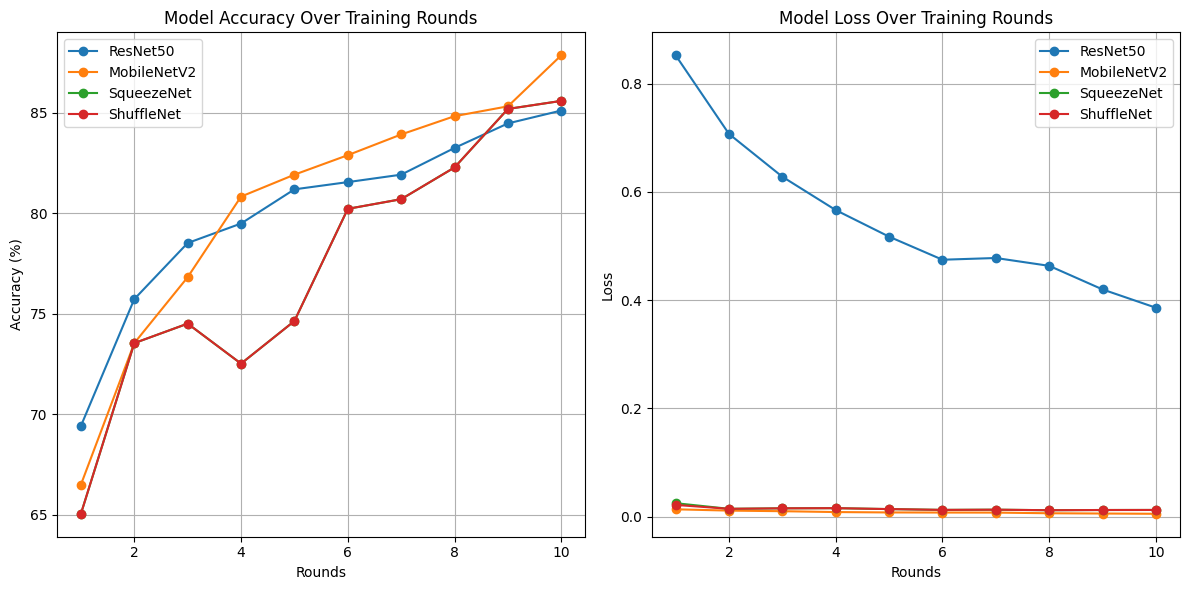

In [ ]:
import matplotlib.pyplot as plt

# Accuracy Data
rounds = list(range(1, 11))
accuracy_resnet50 = [69.42, 75.73, 78.52, 79.49, 81.19, 81.55, 81.92, 83.25, 84.47, 85.11]
accuracy_mobilenetv2 = [66.50, 73.54, 76.82, 80.83, 81.92, 82.89, 83.92, 84.83, 85.32, 87.86]
accuracy_squeezenet = [65.05, 73.54, 74.51, 72.52, 74.64, 80.22, 80.70, 82.28, 85.19, 85.59]
accuracy_shufflenet = [65.05, 73.54, 74.51, 72.52, 74.64, 80.22, 80.70, 82.28, 85.19, 85.59]

# Loss Data
loss_resnet50 = [0.8522, 0.7069, 0.6278, 0.5662, 0.5171, 0.4745, 0.4777, 0.4632, 0.4196, 0.3858]
loss_mobilenetv2 = [0.0135, 0.0111, 0.0100, 0.0084, 0.0077, 0.0075, 0.0074, 0.0062, 0.0057, 0.0052]
loss_squeezenet = [0.0248, 0.0144, 0.0153, 0.0156, 0.0139, 0.0124, 0.0128, 0.0118, 0.0122, 0.0123]
loss_shufflenet = [0.0216, 0.0144, 0.0153, 0.0156, 0.0139, 0.0124, 0.0128, 0.0118, 0.0122, 0.0123]

# Plotting Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(rounds, accuracy_resnet50, label='ResNet50', marker='o')
plt.plot(rounds, accuracy_mobilenetv2, label='MobileNetV2', marker='o')
plt.plot(rounds, accuracy_squeezenet, label='SqueezeNet', marker='o')
plt.plot(rounds, accuracy_shufflenet, label='ShuffleNet', marker='o')
plt.xlabel('Rounds')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Over Training Rounds')
plt.legend()
plt.grid(True)

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(rounds, loss_resnet50, label='ResNet50', marker='o')
plt.plot(rounds, loss_mobilenetv2, label='MobileNetV2', marker='o')
plt.plot(rounds, loss_squeezenet, label='SqueezeNet', marker='o')
plt.plot(rounds, loss_shufflenet, label='ShuffleNet', marker='o')
plt.xlabel('Rounds')
plt.ylabel('Loss')
plt.title('Model Loss Over Training Rounds')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
